In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const


### This tutorial demonstrates how cross-correlation functions relate to the Doppler-shift of planetary signals

Doppler shifts are not linear shifts in wavelength, therefore are subtly different to cross-correlation (or at least fast cross-correlation as implemented in numpy). We can in principle linearise the x-axis in velocity space, in which case we can use simple cross-correlation. As discussed before, writing our own cross-correlation function will enable us to implement Doppler shifts in any wavlength scale, as well as allow much more flexibility in how we do it.

Again, we'll use the same wavelength template to demonstrate how to perform Doppler shifts, then create some simulated 2D datasets and recover the signal.

The basic equation for a Doppler shift is:
$$
\lambda = \lambda_0 ( {1 + \frac{v}{c}} )
$$

where $\lambda$ is the oberved wavelength, $\lambda_0$ is the rest wavelength, $v$ is the *radial* component of the velocity, and $c$ is the speed of light. Note that a positive $v$ leads to a increase in wavelength of a given feature, i.e. a *redshift*.

We can also use the relativistic version:
$$
\lambda = \lambda_0 \sqrt{ \frac{1 + \frac{v}{c}}{1- \frac{v}{c}} },
$$
but the velocities are low enough that it doesn't matter much.



Text(0, 0.5, 'flux')

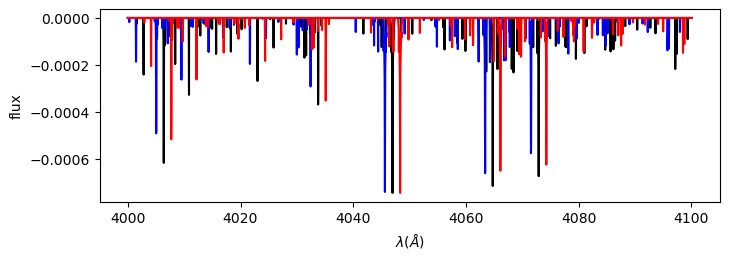

In [2]:
#get the model transmission spectrum from before
wl_template,template = np.load('model_FeI_2500K.npy')

#first we will interpolate the model to a new wavelength scale
wl = np.linspace(4000,4000+100,4000)
signal = np.interp(wl,wl_template,template)

#interpolate signal to redshift and blueshift
vel = 100 #km/s
c = const.c.value #m/s
blue_signal = np.interp(wl*(1+vel*1000/c),wl,signal)
red_signal = np.interp(wl*(1-vel*1000/c),wl,signal)

#alternatively I could do: (note the change of sign!)
# blue_signal = np.interp(wl,wl*(1-vel*1000/c),signal)
# red_signal = np.interp(wl,wl*(1+vel*1000/c),signal)

#make a plot: the signal consists of some spectra lines with continuum at zero
plt.figure(figsize=(8,2.5))
plt.plot(wl,signal,'k-')
plt.plot(wl,blue_signal,'b-')
plt.plot(wl,red_signal,'r-')
plt.xlabel(r'$\lambda (\AA)$')
plt.ylabel('flux')


### Now we can recover the signal using the same cross-correlation methods as before

*Note that now we will use the Doppler shift rather than a linear shift*

Text(0, 0.5, 'ccf')

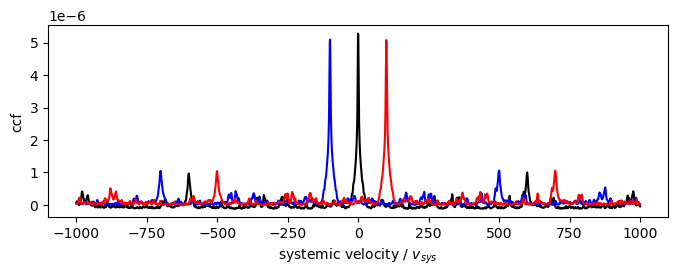

In [3]:

#create array of wavelength shifted spectra
v_sys = np.linspace(-1000,1000,2000) # km/s - this is equivalent to lags, we'll call it v_sys for now, which will become clear later
#W = wl[np.newaxis,:] - (1+v_sys*1000/c)[:,np.newaxis] #create a 2D array of wavelength shifts for each la
W = np.outer(1-v_sys*1000./c,wl) # an outer product also works for multiplication
shifted_templates = np.interp(W,wl_template,template) #shift the 1D model template by each velocity lag

#calculate the CCFs of signal, plus red/blue shifted versions
ccf = np.sum(signal[np.newaxis,:]*shifted_templates,axis=1)
ccf_blue = np.sum(blue_signal[np.newaxis]*shifted_templates,axis=1)
ccf_red = np.sum(red_signal[np.newaxis]*shifted_templates,axis=1)
# ccf = np.dot(signal,shifted_templates) #this can also be done via dot product
# ccf_blue = np.dot(blue_signal,shifted_templates) #this can also be done via dot product
# ccf_red = np.dot(red_signal,shifted_templates) #this can also be done via dot product
ccf = np.dot(shifted_templates-shifted_templates.mean(),signal-signal.mean()) #this can also be done via dot product
ccf_blue = np.dot(shifted_templates,blue_signal) #this can also be done via dot product
ccf_red = np.dot(shifted_templates,red_signal) #this can also be done via dot product

#create a plot of the CCFs
plt.figure(figsize=(8,2.5))
plt.plot(v_sys,ccf,'k-')
plt.plot(v_sys,ccf_blue,'b-')
plt.plot(v_sys,ccf_red,'r-')
plt.xlabel(r'systemic velocity / $v_{sys}$')
plt.ylabel('ccf')


### One final thing is that we can combine the signals into a 2D array, and perform the cross-correaltion at the same time

This will be much more efficient when we shart dealing with large datasets.

Text(0, 0.5, 'ccf')

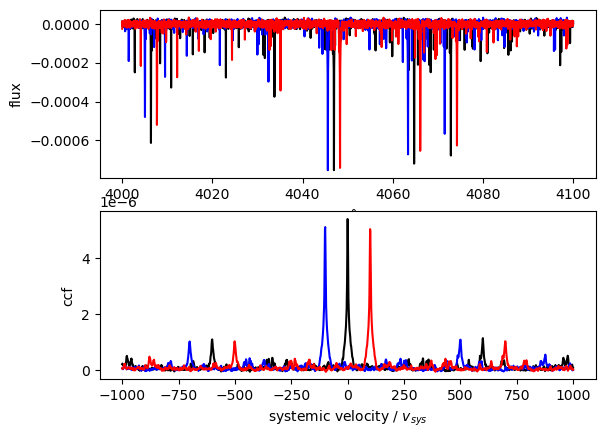

In [4]:

#create the same shifted templates as before
v_sys = np.linspace(-1000,1000,2000)
W = np.outer((1-v_sys*1000./c),wl)
shifted_templates = np.interp(W,wl_template,template)

#combine the signals into a 1D array - n x wavelength
S = np.vstack([blue_signal,signal,red_signal])
#we'll also add some noise this time
N = np.random.normal(0,0.00001,S.shape)
S += N

#and compute all of the cross correlation functions in one line
CC = np.dot(S,shifted_templates.T)
CC = np.sum(S[...,np.newaxis] * shifted_templates.T[np.newaxis,...],axis=1)

#finally plot the data and ccfs
f,a = plt.subplots(2)
a[0].plot(wl,S[1],'k-')
a[0].plot(wl,S[0],'b-')
a[0].plot(wl,S[2],'r-')
a[0].set_xlabel(r'$\lambda (\AA)$')
a[0].set_ylabel('flux')
a[1].plot(v_sys,CC[1],'k-')
a[1].plot(v_sys,CC[0],'b-')
a[1].plot(v_sys,CC[2],'r-')
a[1].set_xlabel(r'systemic velocity / $v_{sys}$')
a[1].set_ylabel('ccf')



Note that we can recover the velocity shifts from the peaks of the CCF. The peaks will vary depending on the noise on each pixel, as well as how well sampled the template and data are - this can effect the interpolation process.